# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0 

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [3]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [4]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(62, 6)


,title,price,year,link,brand,age
0,2015 volkswagen touareg tdi executive sport ut...,13950,2015.0,https://charlottesville.craigslist.org/cto/d/c...,volkswagen,10.0
1,1999 chevy blazer 4wd,2200,1999.0,https://charlottesville.craigslist.org/cto/d/n...,chevy,26.0
2,1997 honda accord lx 2 door,2800,1997.0,https://charlottesville.craigslist.org/cto/d/c...,honda,28.0
3,2004 toyota tundra sr5 for sale - manual tran...,6500,2004.0,https://charlottesville.craigslist.org/cto/d/a...,toyota,21.0
4,"2006 cadillac cts 107,086 miles only",2950,2006.0,https://charlottesville.craigslist.org/cto/d/c...,cadillac,19.0


With the data in and wrangled, we can now do some analysis:

count       62.000000
mean      9549.983871
std      10780.567749
min       2000.000000
25%       3287.500000
50%       6125.000000
75%      10887.500000
max      62800.000000
Name: price, dtype: float64


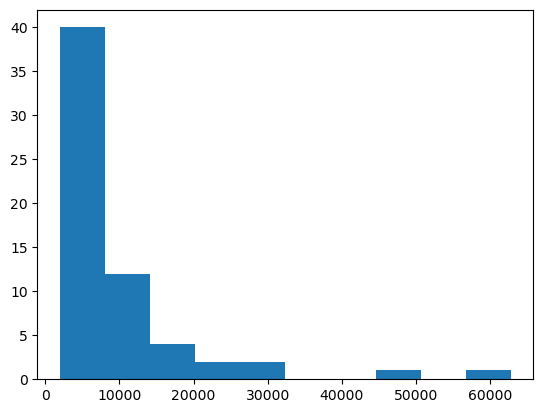

count    57.000000
mean     22.263158
std      14.551051
min       4.000000
25%      13.000000
50%      18.000000
75%      25.000000
max      68.000000
Name: age, dtype: float64


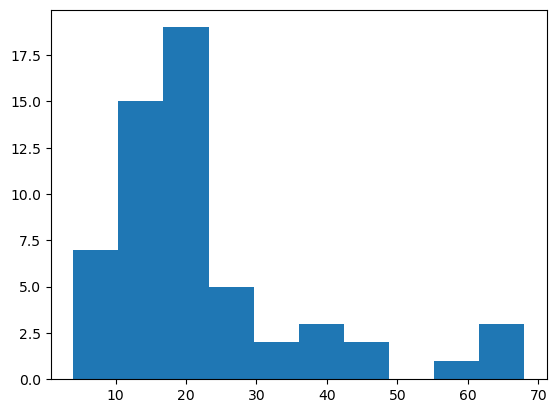

In [5]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [6]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        2.0   5250.000000   3181.980515   3000.0   4125.0   5250.0   
audi         1.0  11000.000000           NaN  11000.0  11000.0  11000.0   
bmw          2.0   8750.000000   1767.766953   7500.0   8125.0   8750.0   
cadillac     1.0   2950.000000           NaN   2950.0   2950.0   2950.0   
chevrolet    2.0   9750.000000   6717.514421   5000.0   7375.0   9750.0   
chevy        4.0   3525.000000   1687.947472   2200.0   2725.0   2950.0   
dodge        2.0   6875.000000   4065.863992   4000.0   5437.5   6875.0   
ford         6.0  18833.333333  15980.196077   4000.0  10500.0  15750.0   
gmc          2.0  16500.000000  13435.028843   7000.0  11750.0  16500.0   
honda       10.0   9020.000000   8044.017791   2800.0   3725.0   6200.0   
jeep         3.0   7900.000000   1429.160593   6250.0   7475.0   8700.0   
kia          1.0   2500.000000           NaN   2500.0   2500.0   2500.0   
lexus        1.0  10950.000000           NaN  10950.0  10950.0  10950.0   
missing     15.0   8756.600000  15884.958851   2000.0   3050.0   3500.0   
mitsubishi   1.0   6800.000000           NaN   6800.0   6800.0   6800.0   
tesla        1.0  26900.000000           NaN  26900.0  26900.0  26900.0   
toyota       5.0   8280.000000   5147.523676   3000.0   5200.0   6500.0   
volkswagen   3.0   7666.666667   5788.854233   2550.0   4525.0   6500.0   

                              
                75%      max  
brand                         
acura        6375.0   7500.0  
audi        11000.0  11000.0  
bmw          9375.0  10000.0  
cadillac     2950.0   2950.0  
chevrolet   12125.0  14500.0  
chevy        3750.0   6000.0  
dodge        8312.5   9750.0  
ford        18375.0  49500.0  
gmc         21250.0  26000.0  
honda       11725.0  29000.0  
jeep         8725.0   8750.0  
kia          2500.0   2500.0  
lexus       10950.0  10950.0  
missing      4499.5  62800.0  
mitsubishi   6800.0   6800.0  
tesla       26900.0  26900.0  
toyota      10700.0  16000.0  
volkswagen  10225.0  13950.0

In [7]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        2.0  15.000000   5.656854  11.0  13.00  15.0  17.00  19.0
audi         1.0   8.000000        NaN   8.0   8.00   8.0   8.00   8.0
bmw          2.0  16.500000   0.707107  16.0  16.25  16.5  16.75  17.0
cadillac     1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0
chevrolet    2.0  47.500000  16.263456  36.0  41.75  47.5  53.25  59.0
chevy        2.0  23.500000   3.535534  21.0  22.25  23.5  24.75  26.0
dodge        2.0  26.500000   6.363961  22.0  24.25  26.5  28.75  31.0
ford         6.0  19.666667   7.941452  11.0  14.00  19.5  22.00  33.0
gmc          1.0  41.000000        NaN  41.0  41.00  41.0  41.00  41.0
honda       10.0  14.100000   6.471304   4.0  11.25  14.0  15.75  28.0
jeep         3.0  14.333333   3.214550  12.0  12.50  13.0  15.50  18.0
kia          1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
lexus        1.0  13.000000        NaN  13.0  13.00  13.0  13.00  13.0
missing     13.0  31.923077  21.398838   7.0  18.00  24.0  46.00  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0
toyota       5.0  19.200000   4.919350  12.0  17.00  21.0  21.00  25.0
volkswagen   3.0  25.333333  17.243356  10.0  16.00  22.0  33.00  44.0

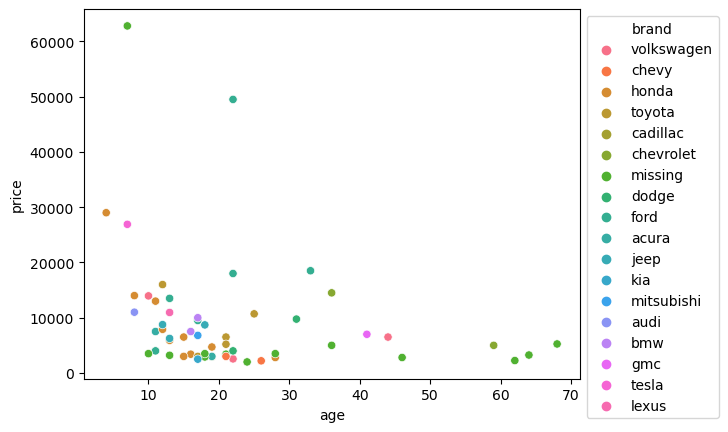

In [8]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.651043 -0.196366
log_age    -0.196366  0.341071
           log_price   log_age
log_price   1.000000 -0.424146
log_age    -0.424146  1.000000


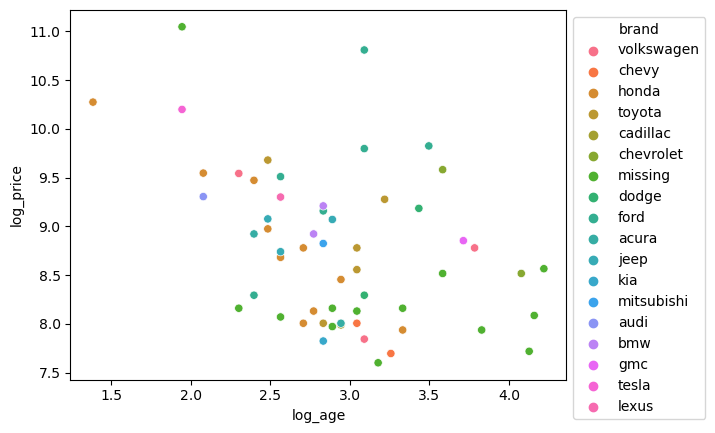

In [9]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

In [10]:
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} 
url = 'https://norfolk.craigslist.org/search/virginia-beach-va/boo?lat=36.9204&lon=-76.0711&search_distance=15&sort=date#search=1~gallery~0~0' # Boats page for VA Beach
raw = requests.get(url,headers=header) # Get boats page

from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want


brands = ['grady white', 'century', 'buddy davis', 'carolina skiff', 'everglade', 'yellowfin', 'baja', 'lund alaskan', 'pearson',
          'boston whaler','sea ray', 'sea-doo', 'mastercraft', 'malibu', 'bennington', 'avalon', 'tracker', 'yamaha', 
          'pelican vortex', 'sea hunt', 'ranger', 'skeeter', 'crestliner', 'nitro', 'xpress', 'lowe',
          'seadoo', 'broward', 'catalina', 'seaswirl', 'supra', 'formula','endeavour', 'bayliner', 'wellcraft','hobie','luhrs',
          'lund','crownline','trinka','harris',]

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

In [16]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df = df.sort_values(by='age')
df.head(10)

(70, 6)


,title,price,year,link,brand,age
12,2023 23' custom dominion boat works,159000,2023.0,https://norfolk.craigslist.org/boa/d/norfolk-c...,missing,2.0
27,2020 h2ob xpress,26500,2020.0,https://norfolk.craigslist.org/boa/d/virginia-...,xpress,5.0
2,"2019 bayliner 190 deck boat, 150hp 4s, galv. t...",1,2019.0,https://annapolis.craigslist.org/boa/d/virgini...,bayliner,6.0
39,2019 yamaha ar210,42000,2019.0,https://norfolk.craigslist.org/boa/d/virginia-...,yamaha,6.0
58,2015 tracker pro guide v-175 combo,17500,2015.0,https://norfolk.craigslist.org/boa/d/virginia-...,tracker,10.0
7,"2012 lund predator | 225hp merc, talon, new ba...",23300,2012.0,https://norfolk.craigslist.org/boa/d/virginia-...,lund,13.0
18,2012/15 carolina skiff dlv wb,44500,2012.0,https://norfolk.craigslist.org/boa/d/virginia-...,missing,13.0
26,"2010 bayliner 245 sb ❋ 394 hours ❋ clean, well...",19999,2010.0,https://norfolk.craigslist.org/boa/d/virginia-...,bayliner,15.0
15,2008 238 dlv carolina skiff,22500,2008.0,https://norfolk.craigslist.org/boa/d/virginia-...,missing,17.0
13,2007 supra launch 24 ssv | gravity games editi...,25900,2007.0,https://norfolk.craigslist.org/boa/d/virginia-...,supra,18.0


count        70.000000
mean      16833.414286
std       26352.515647
min           1.000000
25%        1200.000000
50%       10250.000000
75%       23825.000000
max      159000.000000
Name: price, dtype: float64


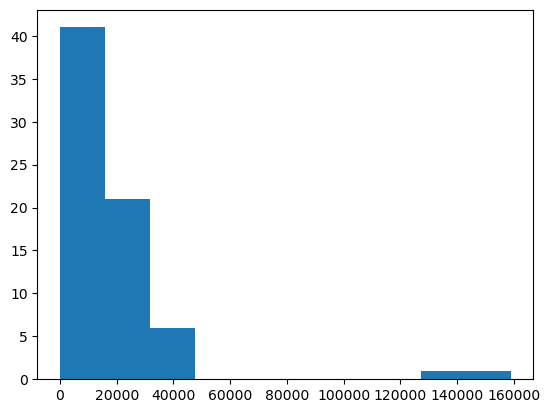

count    21.000000
mean     21.095238
std      13.924456
min       2.000000
25%      13.000000
50%      18.000000
75%      26.000000
max      55.000000
Name: age, dtype: float64


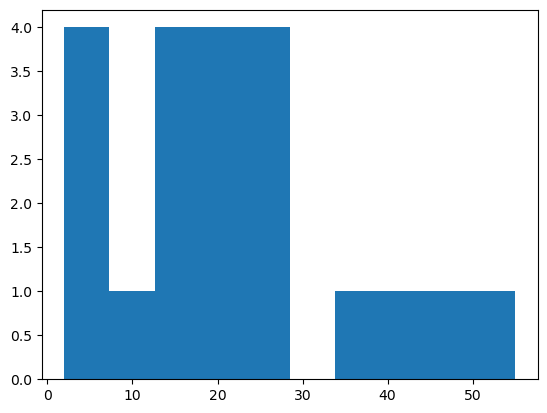

In [17]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [18]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
          count          mean           std      min      25%      50%   
brand                                                                    
avalon      1.0  18700.000000           NaN  18700.0  18700.0  18700.0   
baja        7.0  25000.000000      0.000000  25000.0  25000.0  25000.0   
bayliner    7.0   6714.428571   7139.971355      1.0   1250.5   5500.0   
catalina    1.0      1.000000           NaN      1.0      1.0      1.0   
crownline   1.0  18000.000000           NaN  18000.0  18000.0  18000.0   
endeavour   1.0  23000.000000           NaN  23000.0  23000.0  23000.0   
formula     1.0  35000.000000           NaN  35000.0  35000.0  35000.0   
hobie       1.0   1100.000000           NaN   1100.0   1100.0   1100.0   
luhrs       1.0  41000.000000           NaN  41000.0  41000.0  41000.0   
lund        1.0  23300.000000           NaN  23300.0  23300.0  23300.0   
missing    42.0  15891.357143  32716.751657      1.0    190.0   3997.5   
skeeter     1.0  12000.000000           NaN  12000.0  12000.0  12000.0   
supra       1.0  25900.000000           NaN  25900.0  25900.0  25900.0   
tracker     1.0  17500.000000           NaN  17500.0  17500.0  17500.0   
wellcraft   1.0   4900.000000           NaN   4900.0   4900.0   4900.0   
xpress      1.0  26500.000000           NaN  26500.0  26500.0  26500.0   
yamaha      1.0  42000.000000           NaN  42000.0  42000.0  42000.0   

                              
               75%       max  
brand                         
avalon     18700.0   18700.0  
baja       25000.0   25000.0  
bayliner    9500.0   19999.0  
catalina       1.0       1.0  
crownline  18000.0   18000.0  
endeavour  23000.0   23000.0  
formula    35000.0   35000.0  
hobie       1100.0    1100.0  
luhrs      41000.0   41000.0  
lund       23300.0   23300.0  
missing    16125.0  159000.0  
skeeter    12000.0   12000.0  
supra      25900.0   25900.0  
tracker    17500.0   17500.0  
wellcraft   4900.0    4900.0  
xpress     26500.0   26500.0  
yamaha     42000.0   42000.0

In [19]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
          count       mean        std   min    25%   50%    75%   max
brand                                                                
avalon      0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
baja        0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
bayliner    4.0  16.000000   7.874008   6.0  12.75  16.5  19.75  25.0
catalina    0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
crownline   1.0  25.000000        NaN  25.0  25.00  25.0  25.00  25.0
endeavour   0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
formula     0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
hobie       0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
luhrs       1.0  26.000000        NaN  26.0  26.00  26.0  26.00  26.0
lund        1.0  13.000000        NaN  13.0  13.00  13.0  13.00  13.0
missing     9.0  27.666667  17.464249   2.0  17.00  22.0  40.00  55.0
skeeter     0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
supra       1.0  18.000000        NaN  18.0  18.00  18.0  18.00  18.0
tracker     1.0  10.000000        NaN  10.0  10.00  10.0  10.00  10.0
wellcraft   1.0  27.000000        NaN  27.0  27.00  27.0  27.00  27.0
xpress      1.0   5.000000        NaN   5.0   5.00   5.0   5.00   5.0
yamaha      1.0   6.000000        NaN   6.0   6.00   6.0   6.00   6.0

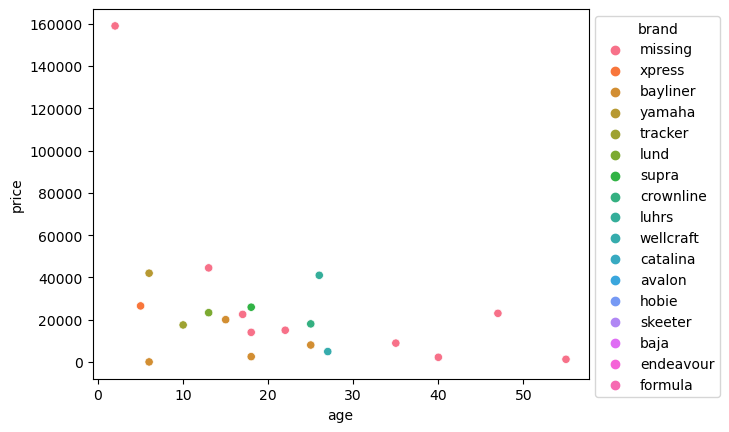

In [20]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price  13.308677 -0.126707
log_age    -0.126707  0.654672
           log_price   log_age
log_price   1.000000 -0.065838
log_age    -0.065838  1.000000


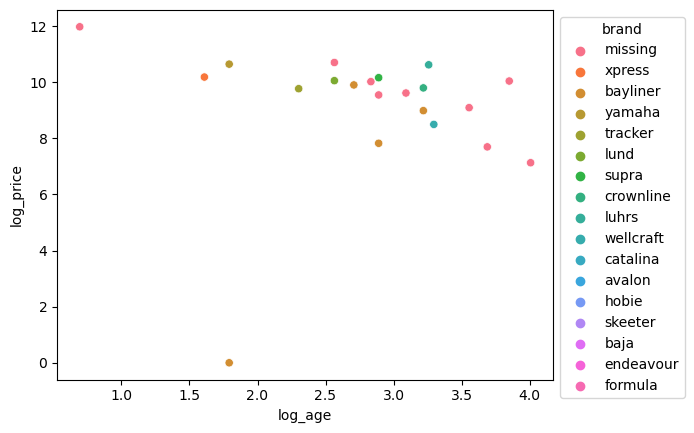

In [21]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

Key Relationships:
- Newer boats (lower age values) tend to have higher prices, with a few exceptions where very young boats have significantly high prices
- As boats age, their prices generally decrease, though there is considerable variation
- There is a negative correlation between log_age and log_price, indicating that as boats age, their prices tend to decrease, though not in a strictly linear fashion
- The majority of the data points cluster in the upper-right portion of the plot, suggesting that many boats retain relatively high value for a significant portion of their lifespan